In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [4]:
logging.info('abc')

07/28/2017 11:18:02 PM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [6]:

import Queue
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=60
            len2=60
            j=int(np.random.random()*(len(row)-len1-1))
            x=row[j:j+len1]
            part_y=row[j+len1:j+len1+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]=1
            self.q.put((np.concatenate([x,attrib_row]).astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X, y,mask = self.q.get()
        self.curr_i += 1
        return X, y,mask 


In [7]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32], 
                                [(72,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [8]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [9]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [10]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [11]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [12]:
daily_data,attrib_data=make_data()

(145063, 550) (145063, 12)


In [16]:
print np.mean(daily_data==0)
daily_data += (daily_data==0)*0.1
print np.mean(daily_data==0)

0.0909115851232
0.0


In [17]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c= generator.next()
    print a,b,c    
    print a.shape,b.shape,c.shape


In [18]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [19]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b

def get_Xy(x_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X, y,mask, l2_scale

In [38]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.y, self.mask, self.l2_scale = get_Xy(x_size,y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer()#.minimize(self.loss)
                    gvs = self.optimizer.compute_gradients(self.loss)
                    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
                    self.train_op = self.optimizer.apply_gradients(capped_gvs)

        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            self._session = tf.Session(graph=self.graph)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)

        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,1,'dense',with_activation=False)
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)
                error=predictions-float_labels                
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels))
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [39]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=75, y_size=60, n_hiddens=[10,10], l2_scale=0.1)
    model.initialize()
    [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [40]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [45]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X, y,mask = sess.run(reader)
                    feed_dict = {model.X:X, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.train_op, model.loss, model.l2_loss], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, L2LOSS: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        # config.gpu_options.per_process_gpu_memory_fraction = 0.3  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(daily_data,attrib_data,batchsize=batch_size,nrows=None)            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, coord) is None:
                        raise Exception("train error")
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [46]:
daily_data.shape

(145063, 550)

In [47]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10,10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[1024,1024]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [48]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=72, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_single_1024', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

07/28/2017 11:26:08 PM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
07/28/2017 11:26:08 PM INFO: MyModel logits shape (?, 1)


(?, 1024)
(?, 1024)
(?, 1)
(145063, 550) (145063, 12)


07/28/2017 11:26:10 PM INFO: shapes: [(72,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32], batchsize: 256
07/28/2017 11:26:10 PM INFO: [epoch 0] start net training
07/28/2017 11:26:21 PM INFO: [epoch 0][step 25600] AVG LOSS: 2.0, L2LOSS: 0.0
07/28/2017 11:26:32 PM INFO: [epoch 0][step 51200] AVG LOSS: 2.0, L2LOSS: 0.0
07/28/2017 11:26:43 PM INFO: [epoch 0][step 76800] AVG LOSS: 1.90982401371, L2LOSS: 0.0
07/28/2017 11:26:53 PM INFO: [epoch 0][step 102400] AVG LOSS: 1.31263852119, L2LOSS: 0.0
07/28/2017 11:27:04 PM INFO: [epoch 0][step 128000] AVG LOSS: 1.06490385532, L2LOSS: 0.0
07/28/2017 11:27:15 PM INFO: [epoch 0][step 153600] AVG LOSS: 0.941281735897, L2LOSS: 0.0
07/28/2017 11:27:26 PM INFO: [epoch 0][step 179200] AVG LOSS: 0.895009994507, L2LOSS: 0.0
07/28/2017 11:27:37 PM INFO: [epoch 0][step 204800] AVG LOSS: 0.881945729256, L2LOSS: 0.0
07/28/2017 11:27:47 PM INFO: [epoch 0][step 230400] AVG LOSS: 0.868984282017, L2LOSS: 0.0
07/28/2017 11:27:58 PM INFO: [epoch 0][s

07/28/2017 11:41:41 PM INFO: [epoch 8][step 153600] AVG LOSS: 0.623739540577, L2LOSS: 0.0
07/28/2017 11:41:52 PM INFO: [epoch 8][step 179200] AVG LOSS: 0.623866438866, L2LOSS: 0.0
07/28/2017 11:42:03 PM INFO: [epoch 8][step 204800] AVG LOSS: 0.632010400295, L2LOSS: 0.0
07/28/2017 11:42:13 PM INFO: [epoch 8][step 230400] AVG LOSS: 0.640292644501, L2LOSS: 0.0
07/28/2017 11:42:24 PM INFO: [epoch 8][step 256000] AVG LOSS: 0.637927293777, L2LOSS: 0.0
07/28/2017 11:42:24 PM INFO: [epoch 9] start net training
07/28/2017 11:42:35 PM INFO: [epoch 9][step 25600] AVG LOSS: 0.638738572598, L2LOSS: 0.0
07/28/2017 11:42:46 PM INFO: [epoch 9][step 51200] AVG LOSS: 0.631434381008, L2LOSS: 0.0
07/28/2017 11:42:57 PM INFO: [epoch 9][step 76800] AVG LOSS: 0.631444871426, L2LOSS: 0.0
07/28/2017 11:43:07 PM INFO: [epoch 9][step 102400] AVG LOSS: 0.630866110325, L2LOSS: 0.0
07/28/2017 11:43:18 PM INFO: [epoch 9][step 128000] AVG LOSS: 0.627926051617, L2LOSS: 0.0
07/28/2017 11:43:29 PM INFO: [epoch 9][step 1

07/28/2017 11:56:53 PM INFO: [epoch 17][step 25600] AVG LOSS: 0.600690126419, L2LOSS: 0.0
07/28/2017 11:57:04 PM INFO: [epoch 17][step 51200] AVG LOSS: 0.600245475769, L2LOSS: 0.0
07/28/2017 11:57:14 PM INFO: [epoch 17][step 76800] AVG LOSS: 0.604634046555, L2LOSS: 0.0
07/28/2017 11:57:25 PM INFO: [epoch 17][step 102400] AVG LOSS: 0.596902370453, L2LOSS: 0.0
07/28/2017 11:57:36 PM INFO: [epoch 17][step 128000] AVG LOSS: 0.601844370365, L2LOSS: 0.0
07/28/2017 11:57:46 PM INFO: [epoch 17][step 153600] AVG LOSS: 0.600551724434, L2LOSS: 0.0
07/28/2017 11:57:57 PM INFO: [epoch 17][step 179200] AVG LOSS: 0.595840632915, L2LOSS: 0.0
07/28/2017 11:58:08 PM INFO: [epoch 17][step 204800] AVG LOSS: 0.598997473717, L2LOSS: 0.0
07/28/2017 11:58:19 PM INFO: [epoch 17][step 230400] AVG LOSS: 0.602029561996, L2LOSS: 0.0
07/28/2017 11:58:29 PM INFO: [epoch 17][step 256000] AVG LOSS: 0.597483694553, L2LOSS: 0.0
07/28/2017 11:58:29 PM INFO: [epoch 18] start net training
07/28/2017 11:58:40 PM INFO: [epoc

07/29/2017 12:12:12 AM INFO: [epoch 25][step 179200] AVG LOSS: 0.590496838093, L2LOSS: 0.0
07/29/2017 12:12:23 AM INFO: [epoch 25][step 204800] AVG LOSS: 0.586054027081, L2LOSS: 0.0
07/29/2017 12:12:33 AM INFO: [epoch 25][step 230400] AVG LOSS: 0.586323916912, L2LOSS: 0.0
07/29/2017 12:12:44 AM INFO: [epoch 25][step 256000] AVG LOSS: 0.620252251625, L2LOSS: 0.0
07/29/2017 12:12:44 AM INFO: [epoch 26] start net training
07/29/2017 12:12:55 AM INFO: [epoch 26][step 25600] AVG LOSS: 0.611649692059, L2LOSS: 0.0
07/29/2017 12:13:05 AM INFO: [epoch 26][step 51200] AVG LOSS: 0.600651502609, L2LOSS: 0.0
07/29/2017 12:13:16 AM INFO: [epoch 26][step 76800] AVG LOSS: 0.592313766479, L2LOSS: 0.0
07/29/2017 12:13:27 AM INFO: [epoch 26][step 102400] AVG LOSS: 0.592731833458, L2LOSS: 0.0
07/29/2017 12:13:37 AM INFO: [epoch 26][step 128000] AVG LOSS: 0.596187949181, L2LOSS: 0.0
07/29/2017 12:13:48 AM INFO: [epoch 26][step 153600] AVG LOSS: 0.590354442596, L2LOSS: 0.0
07/29/2017 12:13:59 AM INFO: [epoc

07/29/2017 12:27:20 AM INFO: [epoch 34][step 51200] AVG LOSS: 0.588605940342, L2LOSS: 0.0
07/29/2017 12:27:31 AM INFO: [epoch 34][step 76800] AVG LOSS: 0.574199020863, L2LOSS: 0.0
07/29/2017 12:27:41 AM INFO: [epoch 34][step 102400] AVG LOSS: 0.578067839146, L2LOSS: 0.0
07/29/2017 12:27:52 AM INFO: [epoch 34][step 128000] AVG LOSS: 0.603538691998, L2LOSS: 0.0
07/29/2017 12:28:03 AM INFO: [epoch 34][step 153600] AVG LOSS: 0.615115225315, L2LOSS: 0.0
07/29/2017 12:28:13 AM INFO: [epoch 34][step 179200] AVG LOSS: 0.588472247124, L2LOSS: 0.0
07/29/2017 12:28:24 AM INFO: [epoch 34][step 204800] AVG LOSS: 0.607641816139, L2LOSS: 0.0
07/29/2017 12:28:35 AM INFO: [epoch 34][step 230400] AVG LOSS: 0.586919009686, L2LOSS: 0.0
07/29/2017 12:28:46 AM INFO: [epoch 34][step 256000] AVG LOSS: 0.579001247883, L2LOSS: 0.0
07/29/2017 12:28:46 AM INFO: [epoch 35] start net training
07/29/2017 12:28:56 AM INFO: [epoch 35][step 25600] AVG LOSS: 0.585183382034, L2LOSS: 0.0
07/29/2017 12:29:07 AM INFO: [epoc

07/29/2017 12:42:38 AM INFO: [epoch 42][step 204800] AVG LOSS: 0.581482708454, L2LOSS: 0.0
07/29/2017 12:42:49 AM INFO: [epoch 42][step 230400] AVG LOSS: 0.581526815891, L2LOSS: 0.0
07/29/2017 12:42:59 AM INFO: [epoch 42][step 256000] AVG LOSS: 0.579426944256, L2LOSS: 0.0
07/29/2017 12:42:59 AM INFO: [epoch 43] start net training
07/29/2017 12:43:10 AM INFO: [epoch 43][step 25600] AVG LOSS: 0.582043230534, L2LOSS: 0.0
07/29/2017 12:43:21 AM INFO: [epoch 43][step 51200] AVG LOSS: 0.576799094677, L2LOSS: 0.0
07/29/2017 12:43:32 AM INFO: [epoch 43][step 76800] AVG LOSS: 0.601609170437, L2LOSS: 0.0
07/29/2017 12:43:42 AM INFO: [epoch 43][step 102400] AVG LOSS: 0.588797390461, L2LOSS: 0.0
07/29/2017 12:43:53 AM INFO: [epoch 43][step 128000] AVG LOSS: 0.578582465649, L2LOSS: 0.0
07/29/2017 12:44:03 AM INFO: [epoch 43][step 153600] AVG LOSS: 0.587166786194, L2LOSS: 0.0
07/29/2017 12:44:14 AM INFO: [epoch 43][step 179200] AVG LOSS: 0.578636050224, L2LOSS: 0.0
07/29/2017 12:44:25 AM INFO: [epoc

07/29/2017 12:57:57 AM INFO: [epoch 51][step 76800] AVG LOSS: 0.572747290134, L2LOSS: 0.0
07/29/2017 12:58:08 AM INFO: [epoch 51][step 102400] AVG LOSS: 0.592828571796, L2LOSS: 0.0
07/29/2017 12:58:18 AM INFO: [epoch 51][step 128000] AVG LOSS: 0.611415803432, L2LOSS: 0.0
07/29/2017 12:58:29 AM INFO: [epoch 51][step 153600] AVG LOSS: 0.588310718536, L2LOSS: 0.0
07/29/2017 12:58:40 AM INFO: [epoch 51][step 179200] AVG LOSS: 0.575542926788, L2LOSS: 0.0
07/29/2017 12:58:50 AM INFO: [epoch 51][step 204800] AVG LOSS: 0.592160284519, L2LOSS: 0.0
07/29/2017 12:59:01 AM INFO: [epoch 51][step 230400] AVG LOSS: 0.589532256126, L2LOSS: 0.0
07/29/2017 12:59:14 AM INFO: [epoch 51][step 256000] AVG LOSS: 0.579663097858, L2LOSS: 0.0
07/29/2017 12:59:14 AM INFO: [epoch 52] start net training
07/29/2017 12:59:28 AM INFO: [epoch 52][step 25600] AVG LOSS: 0.601483523846, L2LOSS: 0.0
07/29/2017 12:59:43 AM INFO: [epoch 52][step 51200] AVG LOSS: 0.609167933464, L2LOSS: 0.0
07/29/2017 12:59:56 AM INFO: [epoc

07/29/2017 01:13:39 AM INFO: [epoch 59][step 230400] AVG LOSS: 0.556658804417, L2LOSS: 0.0
07/29/2017 01:13:49 AM INFO: [epoch 59][step 256000] AVG LOSS: 0.560380518436, L2LOSS: 0.0
07/29/2017 01:13:49 AM INFO: [epoch 60] start net training
07/29/2017 01:14:00 AM INFO: [epoch 60][step 25600] AVG LOSS: 0.560672700405, L2LOSS: 0.0
07/29/2017 01:14:10 AM INFO: [epoch 60][step 51200] AVG LOSS: 0.562362909317, L2LOSS: 0.0
07/29/2017 01:14:21 AM INFO: [epoch 60][step 76800] AVG LOSS: 0.597905576229, L2LOSS: 0.0
07/29/2017 01:14:32 AM INFO: [epoch 60][step 102400] AVG LOSS: 0.577283799648, L2LOSS: 0.0
07/29/2017 01:14:42 AM INFO: [epoch 60][step 128000] AVG LOSS: 0.576078593731, L2LOSS: 0.0
07/29/2017 01:14:53 AM INFO: [epoch 60][step 153600] AVG LOSS: 0.576293230057, L2LOSS: 0.0
07/29/2017 01:15:04 AM INFO: [epoch 60][step 179200] AVG LOSS: 0.588338136673, L2LOSS: 0.0
07/29/2017 01:15:14 AM INFO: [epoch 60][step 204800] AVG LOSS: 0.602313697338, L2LOSS: 0.0
07/29/2017 01:15:25 AM INFO: [epoc

07/29/2017 01:28:46 AM INFO: [epoch 68][step 102400] AVG LOSS: 0.588309407234, L2LOSS: 0.0
07/29/2017 01:28:57 AM INFO: [epoch 68][step 128000] AVG LOSS: 0.555621683598, L2LOSS: 0.0
07/29/2017 01:29:08 AM INFO: [epoch 68][step 153600] AVG LOSS: 0.560400903225, L2LOSS: 0.0
07/29/2017 01:29:18 AM INFO: [epoch 68][step 179200] AVG LOSS: 0.574605226517, L2LOSS: 0.0
07/29/2017 01:29:29 AM INFO: [epoch 68][step 204800] AVG LOSS: 0.597082495689, L2LOSS: 0.0
07/29/2017 01:29:40 AM INFO: [epoch 68][step 230400] AVG LOSS: 0.559136450291, L2LOSS: 0.0
07/29/2017 01:29:50 AM INFO: [epoch 68][step 256000] AVG LOSS: 0.645252525806, L2LOSS: 0.0
07/29/2017 01:29:50 AM INFO: [epoch 69] start net training
07/29/2017 01:30:01 AM INFO: [epoch 69][step 25600] AVG LOSS: 0.565483152866, L2LOSS: 0.0
07/29/2017 01:30:12 AM INFO: [epoch 69][step 51200] AVG LOSS: 0.564539730549, L2LOSS: 0.0
07/29/2017 01:30:22 AM INFO: [epoch 69][step 76800] AVG LOSS: 0.56536090374, L2LOSS: 0.0
07/29/2017 01:30:33 AM INFO: [epoch

07/29/2017 01:44:07 AM INFO: [epoch 76][step 256000] AVG LOSS: 0.582820117474, L2LOSS: 0.0
07/29/2017 01:44:07 AM INFO: [epoch 77] start net training
07/29/2017 01:44:18 AM INFO: [epoch 77][step 25600] AVG LOSS: 0.559450745583, L2LOSS: 0.0
07/29/2017 01:44:29 AM INFO: [epoch 77][step 51200] AVG LOSS: 0.569213271141, L2LOSS: 0.0
07/29/2017 01:44:40 AM INFO: [epoch 77][step 76800] AVG LOSS: 0.553311467171, L2LOSS: 0.0
07/29/2017 01:44:50 AM INFO: [epoch 77][step 102400] AVG LOSS: 0.57973408699, L2LOSS: 0.0
07/29/2017 01:45:01 AM INFO: [epoch 77][step 128000] AVG LOSS: 0.563708662987, L2LOSS: 0.0
07/29/2017 01:45:12 AM INFO: [epoch 77][step 153600] AVG LOSS: 0.541897952557, L2LOSS: 0.0
07/29/2017 01:45:22 AM INFO: [epoch 77][step 179200] AVG LOSS: 0.537705600262, L2LOSS: 0.0
07/29/2017 01:45:33 AM INFO: [epoch 77][step 204800] AVG LOSS: 0.563785552979, L2LOSS: 0.0
07/29/2017 01:45:44 AM INFO: [epoch 77][step 230400] AVG LOSS: 0.565228521824, L2LOSS: 0.0
07/29/2017 01:45:54 AM INFO: [epoch

07/29/2017 01:59:15 AM INFO: [epoch 85][step 128000] AVG LOSS: 0.563716351986, L2LOSS: 0.0
07/29/2017 01:59:26 AM INFO: [epoch 85][step 153600] AVG LOSS: 0.550821602345, L2LOSS: 0.0
07/29/2017 01:59:36 AM INFO: [epoch 85][step 179200] AVG LOSS: 0.567358911037, L2LOSS: 0.0
07/29/2017 01:59:47 AM INFO: [epoch 85][step 204800] AVG LOSS: 0.561916589737, L2LOSS: 0.0
07/29/2017 01:59:58 AM INFO: [epoch 85][step 230400] AVG LOSS: 0.562548995018, L2LOSS: 0.0
07/29/2017 02:00:09 AM INFO: [epoch 85][step 256000] AVG LOSS: 0.554416120052, L2LOSS: 0.0
07/29/2017 02:00:09 AM INFO: [epoch 86] start net training
07/29/2017 02:00:19 AM INFO: [epoch 86][step 25600] AVG LOSS: 0.575840473175, L2LOSS: 0.0
07/29/2017 02:00:30 AM INFO: [epoch 86][step 51200] AVG LOSS: 0.542606532574, L2LOSS: 0.0
07/29/2017 02:00:41 AM INFO: [epoch 86][step 76800] AVG LOSS: 0.548825085163, L2LOSS: 0.0
07/29/2017 02:00:51 AM INFO: [epoch 86][step 102400] AVG LOSS: 0.556916475296, L2LOSS: 0.0
07/29/2017 02:01:02 AM INFO: [epoc

07/29/2017 02:14:23 AM INFO: [epoch 94] start net training
07/29/2017 02:14:34 AM INFO: [epoch 94][step 25600] AVG LOSS: 0.56169885397, L2LOSS: 0.0
07/29/2017 02:14:45 AM INFO: [epoch 94][step 51200] AVG LOSS: 0.560396552086, L2LOSS: 0.0
07/29/2017 02:14:55 AM INFO: [epoch 94][step 76800] AVG LOSS: 0.572287142277, L2LOSS: 0.0
07/29/2017 02:15:06 AM INFO: [epoch 94][step 102400] AVG LOSS: 0.562163949013, L2LOSS: 0.0
07/29/2017 02:15:17 AM INFO: [epoch 94][step 128000] AVG LOSS: 0.547735333443, L2LOSS: 0.0
07/29/2017 02:15:27 AM INFO: [epoch 94][step 153600] AVG LOSS: 0.554847121239, L2LOSS: 0.0
07/29/2017 02:15:38 AM INFO: [epoch 94][step 179200] AVG LOSS: 0.556198596954, L2LOSS: 0.0
07/29/2017 02:15:49 AM INFO: [epoch 94][step 204800] AVG LOSS: 0.578673958778, L2LOSS: 0.0
07/29/2017 02:16:00 AM INFO: [epoch 94][step 230400] AVG LOSS: 0.549997627735, L2LOSS: 0.0
07/29/2017 02:16:10 AM INFO: [epoch 94][step 256000] AVG LOSS: 0.582460939884, L2LOSS: 0.0
07/29/2017 02:16:10 AM INFO: [epoch

07/29/2017 02:29:42 AM INFO: [epoch 102][step 153600] AVG LOSS: 0.543891429901, L2LOSS: 0.0
07/29/2017 02:29:52 AM INFO: [epoch 102][step 179200] AVG LOSS: 0.563165426254, L2LOSS: 0.0
07/29/2017 02:30:03 AM INFO: [epoch 102][step 204800] AVG LOSS: 0.557565629482, L2LOSS: 0.0
07/29/2017 02:30:14 AM INFO: [epoch 102][step 230400] AVG LOSS: 0.56759762764, L2LOSS: 0.0
07/29/2017 02:30:24 AM INFO: [epoch 102][step 256000] AVG LOSS: 0.544781506062, L2LOSS: 0.0
07/29/2017 02:30:25 AM INFO: [epoch 103] start net training
07/29/2017 02:30:35 AM INFO: [epoch 103][step 25600] AVG LOSS: 0.552063465118, L2LOSS: 0.0
07/29/2017 02:30:46 AM INFO: [epoch 103][step 51200] AVG LOSS: 0.550045251846, L2LOSS: 0.0
07/29/2017 02:30:57 AM INFO: [epoch 103][step 76800] AVG LOSS: 0.548114538193, L2LOSS: 0.0
07/29/2017 02:31:07 AM INFO: [epoch 103][step 102400] AVG LOSS: 0.556361317635, L2LOSS: 0.0
07/29/2017 02:31:18 AM INFO: [epoch 103][step 128000] AVG LOSS: 0.548476159573, L2LOSS: 0.0
07/29/2017 02:31:29 AM I

07/29/2017 02:44:38 AM INFO: [epoch 111] start net training
07/29/2017 02:44:48 AM INFO: [epoch 111][step 25600] AVG LOSS: 0.550557672977, L2LOSS: 0.0
07/29/2017 02:44:59 AM INFO: [epoch 111][step 51200] AVG LOSS: 0.560774087906, L2LOSS: 0.0
07/29/2017 02:45:10 AM INFO: [epoch 111][step 76800] AVG LOSS: 0.571860790253, L2LOSS: 0.0
07/29/2017 02:45:20 AM INFO: [epoch 111][step 102400] AVG LOSS: 0.579960286617, L2LOSS: 0.0
07/29/2017 02:45:31 AM INFO: [epoch 111][step 128000] AVG LOSS: 0.564099490643, L2LOSS: 0.0
07/29/2017 02:45:42 AM INFO: [epoch 111][step 153600] AVG LOSS: 0.558889091015, L2LOSS: 0.0
07/29/2017 02:45:52 AM INFO: [epoch 111][step 179200] AVG LOSS: 0.568481326103, L2LOSS: 0.0
07/29/2017 02:46:03 AM INFO: [epoch 111][step 204800] AVG LOSS: 0.5580701828, L2LOSS: 0.0
07/29/2017 02:46:14 AM INFO: [epoch 111][step 230400] AVG LOSS: 0.564299345016, L2LOSS: 0.0
07/29/2017 02:46:24 AM INFO: [epoch 111][step 256000] AVG LOSS: 0.557256937027, L2LOSS: 0.0
07/29/2017 02:46:25 AM IN

07/29/2017 02:59:46 AM INFO: [epoch 119][step 128000] AVG LOSS: 0.636564791203, L2LOSS: 0.0
07/29/2017 02:59:56 AM INFO: [epoch 119][step 153600] AVG LOSS: 0.631374537945, L2LOSS: 0.0
07/29/2017 03:00:07 AM INFO: [epoch 119][step 179200] AVG LOSS: 0.583531439304, L2LOSS: 0.0
07/29/2017 03:00:18 AM INFO: [epoch 119][step 204800] AVG LOSS: 0.57203066349, L2LOSS: 0.0
07/29/2017 03:00:28 AM INFO: [epoch 119][step 230400] AVG LOSS: 0.566748559475, L2LOSS: 0.0
07/29/2017 03:00:39 AM INFO: [epoch 119][step 256000] AVG LOSS: 0.566036581993, L2LOSS: 0.0
07/29/2017 03:00:39 AM INFO: [epoch 120] start net training
07/29/2017 03:00:50 AM INFO: [epoch 120][step 25600] AVG LOSS: 0.563257455826, L2LOSS: 0.0
07/29/2017 03:01:01 AM INFO: [epoch 120][step 51200] AVG LOSS: 0.566009998322, L2LOSS: 0.0
07/29/2017 03:01:11 AM INFO: [epoch 120][step 76800] AVG LOSS: 0.543216407299, L2LOSS: 0.0
07/29/2017 03:01:22 AM INFO: [epoch 120][step 102400] AVG LOSS: 0.543710827827, L2LOSS: 0.0
07/29/2017 03:01:33 AM I

07/29/2017 03:14:55 AM INFO: [epoch 127][step 256000] AVG LOSS: 0.554415762424, L2LOSS: 0.0
07/29/2017 03:14:55 AM INFO: [epoch 128] start net training
07/29/2017 03:15:05 AM INFO: [epoch 128][step 25600] AVG LOSS: 0.567310273647, L2LOSS: 0.0
07/29/2017 03:15:16 AM INFO: [epoch 128][step 51200] AVG LOSS: 0.55926066637, L2LOSS: 0.0
07/29/2017 03:15:27 AM INFO: [epoch 128][step 76800] AVG LOSS: 0.536155283451, L2LOSS: 0.0
07/29/2017 03:15:37 AM INFO: [epoch 128][step 102400] AVG LOSS: 0.54623991251, L2LOSS: 0.0
07/29/2017 03:15:48 AM INFO: [epoch 128][step 128000] AVG LOSS: 0.557595193386, L2LOSS: 0.0
07/29/2017 03:15:59 AM INFO: [epoch 128][step 153600] AVG LOSS: 0.532513558865, L2LOSS: 0.0
07/29/2017 03:16:09 AM INFO: [epoch 128][step 179200] AVG LOSS: 0.549463033676, L2LOSS: 0.0
07/29/2017 03:16:20 AM INFO: [epoch 128][step 204800] AVG LOSS: 0.547696471214, L2LOSS: 0.0
07/29/2017 03:16:31 AM INFO: [epoch 128][step 230400] AVG LOSS: 0.543573737144, L2LOSS: 0.0
07/29/2017 03:16:42 AM IN

07/29/2017 03:29:53 AM INFO: [epoch 136][step 102400] AVG LOSS: 0.544836699963, L2LOSS: 0.0
07/29/2017 03:30:03 AM INFO: [epoch 136][step 128000] AVG LOSS: 0.535381913185, L2LOSS: 0.0
07/29/2017 03:30:14 AM INFO: [epoch 136][step 153600] AVG LOSS: 0.546304941177, L2LOSS: 0.0
07/29/2017 03:30:25 AM INFO: [epoch 136][step 179200] AVG LOSS: 0.533457994461, L2LOSS: 0.0
07/29/2017 03:30:36 AM INFO: [epoch 136][step 204800] AVG LOSS: 0.534620344639, L2LOSS: 0.0
07/29/2017 03:30:46 AM INFO: [epoch 136][step 230400] AVG LOSS: 0.558278441429, L2LOSS: 0.0
07/29/2017 03:30:57 AM INFO: [epoch 136][step 256000] AVG LOSS: 0.566147983074, L2LOSS: 0.0
07/29/2017 03:30:57 AM INFO: [epoch 137] start net training
07/29/2017 03:31:08 AM INFO: [epoch 137][step 25600] AVG LOSS: 0.551735341549, L2LOSS: 0.0
07/29/2017 03:31:18 AM INFO: [epoch 137][step 51200] AVG LOSS: 0.535954356194, L2LOSS: 0.0
07/29/2017 03:31:29 AM INFO: [epoch 137][step 76800] AVG LOSS: 0.562323749065, L2LOSS: 0.0
07/29/2017 03:31:39 AM 

07/29/2017 03:45:00 AM INFO: [epoch 144][step 230400] AVG LOSS: 0.577896893024, L2LOSS: 0.0
07/29/2017 03:45:11 AM INFO: [epoch 144][step 256000] AVG LOSS: 0.548302173615, L2LOSS: 0.0
07/29/2017 03:45:11 AM INFO: [epoch 145] start net training
07/29/2017 03:45:21 AM INFO: [epoch 145][step 25600] AVG LOSS: 0.5512804389, L2LOSS: 0.0
07/29/2017 03:45:32 AM INFO: [epoch 145][step 51200] AVG LOSS: 0.549354612827, L2LOSS: 0.0
07/29/2017 03:45:43 AM INFO: [epoch 145][step 76800] AVG LOSS: 0.537943601608, L2LOSS: 0.0
07/29/2017 03:45:54 AM INFO: [epoch 145][step 102400] AVG LOSS: 0.550928592682, L2LOSS: 0.0
07/29/2017 03:46:04 AM INFO: [epoch 145][step 128000] AVG LOSS: 0.545998811722, L2LOSS: 0.0
07/29/2017 03:46:15 AM INFO: [epoch 145][step 153600] AVG LOSS: 0.56028097868, L2LOSS: 0.0
07/29/2017 03:46:25 AM INFO: [epoch 145][step 179200] AVG LOSS: 0.537401676178, L2LOSS: 0.0
07/29/2017 03:46:36 AM INFO: [epoch 145][step 204800] AVG LOSS: 0.563288927078, L2LOSS: 0.0
07/29/2017 03:46:47 AM INF

07/29/2017 03:59:57 AM INFO: [epoch 153][step 76800] AVG LOSS: 0.52671790123, L2LOSS: 0.0
07/29/2017 04:00:08 AM INFO: [epoch 153][step 102400] AVG LOSS: 0.534720242023, L2LOSS: 0.0
07/29/2017 04:00:19 AM INFO: [epoch 153][step 128000] AVG LOSS: 0.528449237347, L2LOSS: 0.0
07/29/2017 04:00:29 AM INFO: [epoch 153][step 153600] AVG LOSS: 0.53696000576, L2LOSS: 0.0
07/29/2017 04:00:40 AM INFO: [epoch 153][step 179200] AVG LOSS: 0.52190965414, L2LOSS: 0.0
07/29/2017 04:00:51 AM INFO: [epoch 153][step 204800] AVG LOSS: 0.531981825829, L2LOSS: 0.0
07/29/2017 04:01:01 AM INFO: [epoch 153][step 230400] AVG LOSS: 0.530749619007, L2LOSS: 0.0
07/29/2017 04:01:12 AM INFO: [epoch 153][step 256000] AVG LOSS: 0.550880551338, L2LOSS: 0.0
07/29/2017 04:01:12 AM INFO: [epoch 154] start net training
07/29/2017 04:01:23 AM INFO: [epoch 154][step 25600] AVG LOSS: 0.533147335052, L2LOSS: 0.0
07/29/2017 04:01:33 AM INFO: [epoch 154][step 51200] AVG LOSS: 0.523225843906, L2LOSS: 0.0
07/29/2017 04:01:44 AM INF

07/29/2017 04:15:05 AM INFO: [epoch 161][step 204800] AVG LOSS: 0.54869389534, L2LOSS: 0.0
07/29/2017 04:15:16 AM INFO: [epoch 161][step 230400] AVG LOSS: 0.544835865498, L2LOSS: 0.0
07/29/2017 04:15:27 AM INFO: [epoch 161][step 256000] AVG LOSS: 0.530159235001, L2LOSS: 0.0
07/29/2017 04:15:27 AM INFO: [epoch 162] start net training
07/29/2017 04:15:38 AM INFO: [epoch 162][step 25600] AVG LOSS: 0.537636816502, L2LOSS: 0.0
07/29/2017 04:15:48 AM INFO: [epoch 162][step 51200] AVG LOSS: 0.54781883955, L2LOSS: 0.0
07/29/2017 04:15:59 AM INFO: [epoch 162][step 76800] AVG LOSS: 0.538224697113, L2LOSS: 0.0
07/29/2017 04:16:10 AM INFO: [epoch 162][step 102400] AVG LOSS: 0.543974637985, L2LOSS: 0.0
07/29/2017 04:16:20 AM INFO: [epoch 162][step 128000] AVG LOSS: 0.530130147934, L2LOSS: 0.0
07/29/2017 04:16:31 AM INFO: [epoch 162][step 153600] AVG LOSS: 0.549106776714, L2LOSS: 0.0
07/29/2017 04:16:42 AM INFO: [epoch 162][step 179200] AVG LOSS: 0.522766947746, L2LOSS: 0.0
07/29/2017 04:16:52 AM IN

07/29/2017 04:30:04 AM INFO: [epoch 170][step 51200] AVG LOSS: 0.541170060635, L2LOSS: 0.0
07/29/2017 04:30:15 AM INFO: [epoch 170][step 76800] AVG LOSS: 0.547456502914, L2LOSS: 0.0
07/29/2017 04:30:25 AM INFO: [epoch 170][step 102400] AVG LOSS: 0.536594450474, L2LOSS: 0.0
07/29/2017 04:30:36 AM INFO: [epoch 170][step 128000] AVG LOSS: 0.523979187012, L2LOSS: 0.0
07/29/2017 04:30:47 AM INFO: [epoch 170][step 153600] AVG LOSS: 0.539752244949, L2LOSS: 0.0
07/29/2017 04:30:57 AM INFO: [epoch 170][step 179200] AVG LOSS: 0.53444981575, L2LOSS: 0.0
07/29/2017 04:31:08 AM INFO: [epoch 170][step 204800] AVG LOSS: 0.526400208473, L2LOSS: 0.0
07/29/2017 04:31:19 AM INFO: [epoch 170][step 230400] AVG LOSS: 0.528805375099, L2LOSS: 0.0
07/29/2017 04:31:30 AM INFO: [epoch 170][step 256000] AVG LOSS: 0.525215387344, L2LOSS: 0.0
07/29/2017 04:31:30 AM INFO: [epoch 171] start net training
07/29/2017 04:31:40 AM INFO: [epoch 171][step 25600] AVG LOSS: 0.544740021229, L2LOSS: 0.0
07/29/2017 04:31:51 AM I

07/29/2017 04:45:13 AM INFO: [epoch 178][step 179200] AVG LOSS: 0.535736978054, L2LOSS: 0.0
07/29/2017 04:45:23 AM INFO: [epoch 178][step 204800] AVG LOSS: 0.545781195164, L2LOSS: 0.0
07/29/2017 04:45:34 AM INFO: [epoch 178][step 230400] AVG LOSS: 0.534219563007, L2LOSS: 0.0
07/29/2017 04:45:45 AM INFO: [epoch 178][step 256000] AVG LOSS: 0.533466637135, L2LOSS: 0.0
07/29/2017 04:45:45 AM INFO: [epoch 179] start net training
07/29/2017 04:45:56 AM INFO: [epoch 179][step 25600] AVG LOSS: 0.532357275486, L2LOSS: 0.0
07/29/2017 04:46:06 AM INFO: [epoch 179][step 51200] AVG LOSS: 0.549669981003, L2LOSS: 0.0
07/29/2017 04:46:17 AM INFO: [epoch 179][step 76800] AVG LOSS: 0.541835546494, L2LOSS: 0.0
07/29/2017 04:46:28 AM INFO: [epoch 179][step 102400] AVG LOSS: 0.530151665211, L2LOSS: 0.0
07/29/2017 04:46:38 AM INFO: [epoch 179][step 128000] AVG LOSS: 0.545601129532, L2LOSS: 0.0
07/29/2017 04:46:49 AM INFO: [epoch 179][step 153600] AVG LOSS: 0.549972176552, L2LOSS: 0.0
07/29/2017 04:47:00 AM 

07/29/2017 05:00:11 AM INFO: [epoch 187][step 25600] AVG LOSS: 0.522529304028, L2LOSS: 0.0
07/29/2017 05:00:21 AM INFO: [epoch 187][step 51200] AVG LOSS: 0.544858276844, L2LOSS: 0.0
07/29/2017 05:00:32 AM INFO: [epoch 187][step 76800] AVG LOSS: 0.525732636452, L2LOSS: 0.0
07/29/2017 05:00:43 AM INFO: [epoch 187][step 102400] AVG LOSS: 0.520121216774, L2LOSS: 0.0
07/29/2017 05:00:53 AM INFO: [epoch 187][step 128000] AVG LOSS: 0.543815374374, L2LOSS: 0.0
07/29/2017 05:01:04 AM INFO: [epoch 187][step 153600] AVG LOSS: 0.539836883545, L2LOSS: 0.0
07/29/2017 05:01:15 AM INFO: [epoch 187][step 179200] AVG LOSS: 0.556277513504, L2LOSS: 0.0
07/29/2017 05:01:25 AM INFO: [epoch 187][step 204800] AVG LOSS: 0.521449744701, L2LOSS: 0.0
07/29/2017 05:01:36 AM INFO: [epoch 187][step 230400] AVG LOSS: 0.546084463596, L2LOSS: 0.0
07/29/2017 05:01:47 AM INFO: [epoch 187][step 256000] AVG LOSS: 0.53510171175, L2LOSS: 0.0
07/29/2017 05:01:47 AM INFO: [epoch 188] start net training
07/29/2017 05:01:57 AM I

07/29/2017 05:15:19 AM INFO: [epoch 195][step 153600] AVG LOSS: 0.521658837795, L2LOSS: 0.0
07/29/2017 05:15:30 AM INFO: [epoch 195][step 179200] AVG LOSS: 0.548394083977, L2LOSS: 0.0
07/29/2017 05:15:41 AM INFO: [epoch 195][step 204800] AVG LOSS: 0.542213082314, L2LOSS: 0.0
07/29/2017 05:15:51 AM INFO: [epoch 195][step 230400] AVG LOSS: 0.540459156036, L2LOSS: 0.0
07/29/2017 05:16:02 AM INFO: [epoch 195][step 256000] AVG LOSS: 0.543082237244, L2LOSS: 0.0
07/29/2017 05:16:02 AM INFO: [epoch 196] start net training
07/29/2017 05:16:13 AM INFO: [epoch 196][step 25600] AVG LOSS: 0.509904623032, L2LOSS: 0.0
07/29/2017 05:16:23 AM INFO: [epoch 196][step 51200] AVG LOSS: 0.531402230263, L2LOSS: 0.0
07/29/2017 05:16:34 AM INFO: [epoch 196][step 76800] AVG LOSS: 0.54657381773, L2LOSS: 0.0
07/29/2017 05:16:45 AM INFO: [epoch 196][step 102400] AVG LOSS: 0.541030406952, L2LOSS: 0.0
07/29/2017 05:16:55 AM INFO: [epoch 196][step 128000] AVG LOSS: 0.531697273254, L2LOSS: 0.0
07/29/2017 05:17:06 AM I

# predict

In [49]:
sess=tf.Session()

In [50]:
saver = tf.train.import_meta_graph('tmp_pred60_single_1024/model_0-0.meta')

In [52]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_single_1024/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_single_1024/model_0-0


07/29/2017 02:44:28 PM INFO: Restoring parameters from tmp_pred60_single_1024/model_0-0


In [53]:
graph = tf.get_default_graph()

In [54]:
x = graph.get_tensor_by_name("input_x:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [55]:
X=[];Y=[];MASK=[]
for _ in range(1000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=60
    len2=60
    j=int(np.random.random()*(len(row)-len1-1))
    xx=row[j:j+len1]
    part_y=row[j+len1:j+len1+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    mask[:len(part_y)]=1
    a,b,c=(np.concatenate([xx,attrib_row]).astype(np.float32),np.array(yy,dtype=np.float32),mask)
    X.append(a),Y.append(b),MASK.append(c)

In [56]:
X=np.array(X);Y=np.array(Y);MASK=np.array(MASK)
X.shape,Y.shape,MASK.shape

((1000, 72), (1000, 60), (1000, 60))

In [57]:
feed_dict={x:X,y:Y,m:MASK,l2_scale:0}

In [58]:
sess.run(loss,feed_dict=feed_dict)

0.55939275

In [59]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(1000, 1)


In [60]:
a.max(),a.min()

(5133.3276, 1.3166537)

In [61]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0)
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

0
32248.4


0.55939275

In [62]:
MASK.sum()

57649.0

In [65]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape    

615.841 (1000,)


Populating the interactive namespace from numpy and matplotlib
0.615841


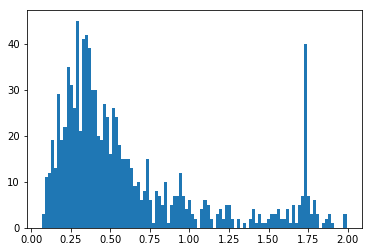

In [66]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

1111.5 1202.77 0.121695


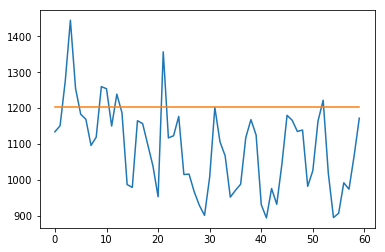

In [76]:
i=857
u=Y[i][:60]
v=[a[i] for _ in range(60)]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

In [77]:
daily_data.shape,attrib_data.shape

((145063, 550), (145063, 12))

In [78]:
daily_test=daily_data[:,-60:]
attrib_test=attrib_data
daily_test.shape,attrib_test.shape

((145063, 60), (145063, 12))

In [79]:
testX=np.concatenate([daily_test,attrib_test],axis=1)
testX.shape

(145063, 72)

In [80]:
feed_dict={x:testX}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 1)

In [81]:
predTest=np.round(predTest,1)
np.mean(predTest<1)

0.0

In [88]:
predTest=np.repeat(predTest,60,axis=1)
predTest.shape

(145063, 60)

In [82]:
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [ ]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [90]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  19.299999
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.600000
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.600000
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.100000
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.900000

In [91]:
submission.shape

(8703780, 2)

In [92]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [93]:
keys_dict=keys["Id"].to_dict()

In [94]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [95]:
submission.isnull().sum().sum()

0L

In [96]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  19.299999  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  19.600000  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.600000  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.100000  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.900000  75bae1fb2637

In [97]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_s_60.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")